In [4]:
from transformers import pipeline, TrainingArguments, Trainer

pipe = pipeline("audio-classification", model="hughlan1214/Speech_Emotion_Recognition_wav2vec2-large-xlsr-53_240304_SER_fine-tuned2.0")

2024-05-12 00:24:48.133964: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset
import pandas as pd
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
from torchsummary import summary
import optuna
import IPython
import librosa
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
class EmotionDataset(Dataset):
    def __init__(self, data_path, data_dir, final_sample_rate, num_samples_limit, transformation, device):
        
        self.data_path = data_path
        
        self.data_dir = data_dir
        if self.data_dir[-1] != '/':
            self.data_dir += '/'
        
        self.final_sample_rate = final_sample_rate
        self.num_samples_limit = num_samples_limit
        self.device = device
        self.transformation = transformation.to(self.device)
        self.df = pd.read_csv(data_path)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        audio_path = self.get_audio_path(index)
        label = self.get_label(index)
        signal, sr = torchaudio.load(audio_path)
        
        signal = signal.to(self.device)
        signal = self.to_mono_if_necessary(signal)
        signal = self.resample_if_necessary(signal, sr)
        signal = self.cut_down_if_necessary(signal)
        signal = self.right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        
        signal[signal == 0] = 0.000000001
        signal = torch.log(signal)
        
        return signal, label
    
    def resample_if_necessary(self, signal, original_sr):
        if original_sr != self.final_sample_rate:
            resampler = torchaudio.transforms.Resample(original_sr, self.final_sample_rate)
            signal = resampler(signal)
        
        return signal
    
    def to_mono_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
    
    def cut_down_if_necessary(self, signal):
        return signal[:, :self.num_samples_limit]
    
    def right_pad_if_necessary(self, signal):
        if signal.shape[1] < self.num_samples_limit:
            num_missing_samples = self.num_samples_limit - signal.shape[1]
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal
        
    def get_audio_path(self, index):
        return self.data_dir + self.df.iloc[index].filename
    
    def get_label(self, index):
        return self.df.iloc[index].category_num
    
    def plot_spectrogram(self, index, log=True):
        spec = self.__getitem__(index)[0]
        spec = spec.cpu().numpy().reshape(spec.shape[1], -1)
        frame_rate = self.final_sample_rate / self.transformation.hop_length
        seconds = np.arange(spec.shape[1]) / frame_rate
        
        if not log:
            spec = np.exp(spec)
        
        plt.figure(figsize=(10, 6))
        plt.imshow(spec, cmap='inferno', origin='lower', aspect='auto')
        plt.xlabel('Time (s)')
        plt.ylabel('Mel')
        plt.colorbar(label='Intensity (dB)')
        plt.xticks(np.linspace(0, spec.shape[1], 12)[:-1], np.linspace(0, seconds[-1], 12).round(2)[:-1])
        plt.show()

In [7]:
RECORDING_DF_PATH = os.path.join('..', 'data', 'recording_paths.csv')
DATA_DIR = os.path.join('..', 'data', 'Crema')
FINAL_SR = 16000
NUM_SAMPLES_LIMIT = 60000
BATCH_SIZE = 128
EPOCHS = 25
LEARNING_RATE = 0.0001

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=FINAL_SR,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
emd = EmotionDataset(RECORDING_DF_PATH, DATA_DIR, FINAL_SR, NUM_SAMPLES_LIMIT, mel_spectrogram, device)
emd.__getitem__(0)

(tensor([[[  0.3558,  -2.2194,  -2.5258,  ..., -20.7233, -20.7233, -20.7233],
          [ -1.2665,  -1.1730,  -1.2424,  ..., -20.7233, -20.7233, -20.7233],
          [  0.1233,  -0.4570,   0.4130,  ..., -20.7233, -20.7233, -20.7233],
          ...,
          [ -6.7543,  -6.4962,  -6.8522,  ..., -20.7233, -20.7233, -20.7233],
          [ -6.2836,  -6.7988,  -6.3462,  ..., -20.7233, -20.7233, -20.7233],
          [ -6.6783,  -6.7656,  -6.2225,  ..., -20.7233, -20.7233, -20.7233]]],
        device='cuda:0'),
 1)

In [8]:
wav_files = [file for file in os.listdir(DATA_DIR) if file.endswith('.wav')]

In [9]:
i = 0
for wav_file in wav_files:
    if i == 20:
        break
        
    audio_file = os.path.join(DATA_DIR, wav_file)
    
    audio = IPython.display.Audio(audio_file, rate=FINAL_SR)
    display(audio)
    print(f"ITER {i + 1}", wav_file)
    i += 1

ITER 1 1054_IEO_DIS_LO.wav


ITER 2 1001_TSI_ANG_XX.wav


ITER 3 1019_IOM_DIS_XX.wav


ITER 4 1068_WSI_DIS_XX.wav


ITER 5 1025_ITS_DIS_XX.wav


ITER 6 1006_DFA_NEU_XX.wav


ITER 7 1037_IWL_NEU_XX.wav


ITER 8 1076_WSI_DIS_XX.wav


ITER 9 1007_IOM_DIS_XX.wav


ITER 10 1029_IWL_NEU_XX.wav


ITER 11 1018_DFA_NEU_XX.wav


ITER 12 1054_DFA_FEA_XX.wav


ITER 13 1065_IWL_FEA_XX.wav


ITER 14 1055_ITS_ANG_XX.wav


ITER 15 1066_DFA_HAP_XX.wav


ITER 16 1057_IWL_HAP_XX.wav


ITER 17 1069_IOM_ANG_XX.wav


ITER 18 1089_IEO_FEA_MD.wav


ITER 19 1018_WSI_ANG_XX.wav


ITER 20 1080_TAI_FEA_XX.wav


In [10]:
emotions = {'DIS': 'disgust', 'ANG': 'angry', 'FEA': 'fear', 'HAP': 'happy', 'NEU': 'neutral', 'SAD': 'sad'}

i = 0
count_accuracy = 0
total_iterations = 0
actual_labels = []
predicted_labels = []
for wav_file in wav_files:
#     if i == 1000:
#         break
    # Construct the full path to the audio file
    audio_file = os.path.join(DATA_DIR, wav_file)
    
    actual_label = emotions[wav_file.split('_')[2]]
    predicted_label = pipe(audio_file)[0]['label']
    
    actual_labels.append(actual_label)
    predicted_labels.append(predicted_label)
    
    print(f"ITER {i + 1}:", predicted_label)
    
    if actual_label == predicted_label:
        count_accuracy += 1
    
    total_iterations += 1
        
    i += 1

accuracy = count_accuracy / total_iterations
print(f"accuracy: {accuracy}")


ITER 1: disgust
ITER 2: angry
ITER 3: disgust
ITER 4: happy
ITER 5: disgust
ITER 6: neutral
ITER 7: neutral
ITER 8: disgust
ITER 9: disgust
ITER 10: neutral
ITER 11: neutral
ITER 12: sad
ITER 13: fear
ITER 14: angry
ITER 15: happy
ITER 16: angry
ITER 17: angry
ITER 18: fear
ITER 19: angry
ITER 20: fear
ITER 21: happy
ITER 22: happy
ITER 23: angry
ITER 24: angry
ITER 25: angry
ITER 26: neutral
ITER 27: sad
ITER 28: disgust
ITER 29: neutral
ITER 30: sad
ITER 31: happy
ITER 32: sad
ITER 33: angry
ITER 34: fear
ITER 35: sad
ITER 36: neutral
ITER 37: fear
ITER 38: happy
ITER 39: neutral
ITER 40: angry
ITER 41: disgust
ITER 42: disgust
ITER 43: happy
ITER 44: disgust
ITER 45: angry
ITER 46: happy
ITER 47: angry
ITER 48: sad
ITER 49: neutral
ITER 50: happy
ITER 51: neutral
ITER 52: neutral
ITER 53: angry
ITER 54: neutral
ITER 55: angry
ITER 56: neutral
ITER 57: neutral
ITER 58: neutral
ITER 59: happy
ITER 60: happy
ITER 61: happy
ITER 62: angry
ITER 63: happy
ITER 64: angry
ITER 65: happy
ITE

ITER 506: happy
ITER 507: neutral
ITER 508: happy
ITER 509: disgust
ITER 510: sad
ITER 511: angry
ITER 512: disgust
ITER 513: sad
ITER 514: angry
ITER 515: happy
ITER 516: disgust
ITER 517: neutral
ITER 518: neutral
ITER 519: neutral
ITER 520: sad
ITER 521: happy
ITER 522: sad
ITER 523: neutral
ITER 524: neutral
ITER 525: disgust
ITER 526: neutral
ITER 527: disgust
ITER 528: angry
ITER 529: happy
ITER 530: happy
ITER 531: angry
ITER 532: sad
ITER 533: angry
ITER 534: disgust
ITER 535: happy
ITER 536: neutral
ITER 537: angry
ITER 538: sad
ITER 539: neutral
ITER 540: fear
ITER 541: neutral
ITER 542: sad
ITER 543: disgust
ITER 544: neutral
ITER 545: sad
ITER 546: neutral
ITER 547: happy
ITER 548: fear
ITER 549: neutral
ITER 550: neutral
ITER 551: disgust
ITER 552: happy
ITER 553: neutral
ITER 554: happy
ITER 555: fear
ITER 556: neutral
ITER 557: disgust
ITER 558: angry
ITER 559: happy
ITER 560: happy
ITER 561: neutral
ITER 562: disgust
ITER 563: angry
ITER 564: sad
ITER 565: sad
ITER 566:

ITER 1003: happy
ITER 1004: sad
ITER 1005: sad
ITER 1006: happy
ITER 1007: angry
ITER 1008: neutral
ITER 1009: angry
ITER 1010: happy
ITER 1011: angry
ITER 1012: sad
ITER 1013: neutral
ITER 1014: fear
ITER 1015: angry
ITER 1016: disgust
ITER 1017: sad
ITER 1018: neutral
ITER 1019: sad
ITER 1020: neutral
ITER 1021: fear
ITER 1022: sad
ITER 1023: happy
ITER 1024: neutral
ITER 1025: sad
ITER 1026: happy
ITER 1027: happy
ITER 1028: happy
ITER 1029: angry
ITER 1030: angry
ITER 1031: happy
ITER 1032: disgust
ITER 1033: angry
ITER 1034: sad
ITER 1035: angry
ITER 1036: disgust
ITER 1037: sad
ITER 1038: disgust
ITER 1039: neutral
ITER 1040: sad
ITER 1041: fear
ITER 1042: neutral
ITER 1043: disgust
ITER 1044: sad
ITER 1045: neutral
ITER 1046: fear
ITER 1047: fear
ITER 1048: disgust
ITER 1049: disgust
ITER 1050: neutral
ITER 1051: neutral
ITER 1052: sad
ITER 1053: sad
ITER 1054: fear
ITER 1055: sad
ITER 1056: happy
ITER 1057: disgust
ITER 1058: angry
ITER 1059: disgust
ITER 1060: neutral
ITER 106

ITER 1473: neutral
ITER 1474: disgust
ITER 1475: happy
ITER 1476: neutral
ITER 1477: disgust
ITER 1478: disgust
ITER 1479: happy
ITER 1480: neutral
ITER 1481: disgust
ITER 1482: disgust
ITER 1483: sad
ITER 1484: angry
ITER 1485: angry
ITER 1486: angry
ITER 1487: angry
ITER 1488: neutral
ITER 1489: angry
ITER 1490: happy
ITER 1491: fear
ITER 1492: disgust
ITER 1493: disgust
ITER 1494: neutral
ITER 1495: disgust
ITER 1496: neutral
ITER 1497: happy
ITER 1498: neutral
ITER 1499: disgust
ITER 1500: happy
ITER 1501: neutral
ITER 1502: disgust
ITER 1503: disgust
ITER 1504: disgust
ITER 1505: happy
ITER 1506: happy
ITER 1507: sad
ITER 1508: happy
ITER 1509: sad
ITER 1510: disgust
ITER 1511: neutral
ITER 1512: sad
ITER 1513: neutral
ITER 1514: neutral
ITER 1515: neutral
ITER 1516: angry
ITER 1517: fear
ITER 1518: disgust
ITER 1519: sad
ITER 1520: disgust
ITER 1521: neutral
ITER 1522: disgust
ITER 1523: neutral
ITER 1524: happy
ITER 1525: happy
ITER 1526: angry
ITER 1527: happy
ITER 1528: happy


ITER 1941: sad
ITER 1942: sad
ITER 1943: angry
ITER 1944: disgust
ITER 1945: happy
ITER 1946: neutral
ITER 1947: happy
ITER 1948: disgust
ITER 1949: sad
ITER 1950: disgust
ITER 1951: disgust
ITER 1952: disgust
ITER 1953: sad
ITER 1954: disgust
ITER 1955: happy
ITER 1956: happy
ITER 1957: fear
ITER 1958: neutral
ITER 1959: angry
ITER 1960: disgust
ITER 1961: neutral
ITER 1962: neutral
ITER 1963: neutral
ITER 1964: happy
ITER 1965: neutral
ITER 1966: happy
ITER 1967: sad
ITER 1968: happy
ITER 1969: sad
ITER 1970: fear
ITER 1971: neutral
ITER 1972: sad
ITER 1973: sad
ITER 1974: disgust
ITER 1975: disgust
ITER 1976: sad
ITER 1977: disgust
ITER 1978: happy
ITER 1979: disgust
ITER 1980: happy
ITER 1981: angry
ITER 1982: sad
ITER 1983: happy
ITER 1984: neutral
ITER 1985: happy
ITER 1986: angry
ITER 1987: happy
ITER 1988: angry
ITER 1989: angry
ITER 1990: disgust
ITER 1991: neutral
ITER 1992: disgust
ITER 1993: sad
ITER 1994: neutral
ITER 1995: disgust
ITER 1996: disgust
ITER 1997: angry
ITER 

ITER 2414: angry
ITER 2415: disgust
ITER 2416: sad
ITER 2417: sad
ITER 2418: sad
ITER 2419: neutral
ITER 2420: disgust
ITER 2421: sad
ITER 2422: happy
ITER 2423: sad
ITER 2424: happy
ITER 2425: happy
ITER 2426: neutral
ITER 2427: neutral
ITER 2428: fear
ITER 2429: happy
ITER 2430: disgust
ITER 2431: disgust
ITER 2432: neutral
ITER 2433: sad
ITER 2434: disgust
ITER 2435: neutral
ITER 2436: sad
ITER 2437: angry
ITER 2438: neutral
ITER 2439: sad
ITER 2440: angry
ITER 2441: happy
ITER 2442: happy
ITER 2443: happy
ITER 2444: neutral
ITER 2445: sad
ITER 2446: neutral
ITER 2447: happy
ITER 2448: happy
ITER 2449: sad
ITER 2450: neutral
ITER 2451: angry
ITER 2452: neutral
ITER 2453: disgust
ITER 2454: neutral
ITER 2455: sad
ITER 2456: fear
ITER 2457: angry
ITER 2458: neutral
ITER 2459: disgust
ITER 2460: angry
ITER 2461: happy
ITER 2462: neutral
ITER 2463: disgust
ITER 2464: angry
ITER 2465: angry
ITER 2466: happy
ITER 2467: happy
ITER 2468: angry
ITER 2469: sad
ITER 2470: angry
ITER 2471: happ

ITER 2885: neutral
ITER 2886: happy
ITER 2887: angry
ITER 2888: happy
ITER 2889: neutral
ITER 2890: disgust
ITER 2891: angry
ITER 2892: angry
ITER 2893: happy
ITER 2894: sad
ITER 2895: neutral
ITER 2896: happy
ITER 2897: disgust
ITER 2898: happy
ITER 2899: sad
ITER 2900: disgust
ITER 2901: happy
ITER 2902: sad
ITER 2903: disgust
ITER 2904: disgust
ITER 2905: sad
ITER 2906: sad
ITER 2907: angry
ITER 2908: sad
ITER 2909: fear
ITER 2910: angry
ITER 2911: angry
ITER 2912: disgust
ITER 2913: angry
ITER 2914: neutral
ITER 2915: angry
ITER 2916: neutral
ITER 2917: neutral
ITER 2918: fear
ITER 2919: angry
ITER 2920: happy
ITER 2921: neutral
ITER 2922: sad
ITER 2923: sad
ITER 2924: disgust
ITER 2925: neutral
ITER 2926: disgust
ITER 2927: angry
ITER 2928: angry
ITER 2929: happy
ITER 2930: disgust
ITER 2931: happy
ITER 2932: angry
ITER 2933: happy
ITER 2934: angry
ITER 2935: sad
ITER 2936: fear
ITER 2937: sad
ITER 2938: sad
ITER 2939: neutral
ITER 2940: angry
ITER 2941: disgust
ITER 2942: sad
ITE

ITER 3360: disgust
ITER 3361: fear
ITER 3362: sad
ITER 3363: neutral
ITER 3364: happy
ITER 3365: happy
ITER 3366: angry
ITER 3367: angry
ITER 3368: sad
ITER 3369: happy
ITER 3370: happy
ITER 3371: neutral
ITER 3372: angry
ITER 3373: happy
ITER 3374: angry
ITER 3375: fear
ITER 3376: disgust
ITER 3377: disgust
ITER 3378: sad
ITER 3379: neutral
ITER 3380: neutral
ITER 3381: neutral
ITER 3382: neutral
ITER 3383: disgust
ITER 3384: angry
ITER 3385: disgust
ITER 3386: fear
ITER 3387: neutral
ITER 3388: happy
ITER 3389: disgust
ITER 3390: sad
ITER 3391: fear
ITER 3392: neutral
ITER 3393: angry
ITER 3394: sad
ITER 3395: disgust
ITER 3396: neutral
ITER 3397: disgust
ITER 3398: neutral
ITER 3399: angry
ITER 3400: sad
ITER 3401: disgust
ITER 3402: sad
ITER 3403: disgust
ITER 3404: happy
ITER 3405: happy
ITER 3406: neutral
ITER 3407: neutral
ITER 3408: disgust
ITER 3409: happy
ITER 3410: neutral
ITER 3411: angry
ITER 3412: sad
ITER 3413: angry
ITER 3414: disgust
ITER 3415: neutral
ITER 3416: angry

ITER 3830: neutral
ITER 3831: angry
ITER 3832: neutral
ITER 3833: angry
ITER 3834: neutral
ITER 3835: sad
ITER 3836: disgust
ITER 3837: sad
ITER 3838: sad
ITER 3839: neutral
ITER 3840: disgust
ITER 3841: disgust
ITER 3842: sad
ITER 3843: neutral
ITER 3844: happy
ITER 3845: disgust
ITER 3846: sad
ITER 3847: sad
ITER 3848: fear
ITER 3849: sad
ITER 3850: sad
ITER 3851: happy
ITER 3852: happy
ITER 3853: sad
ITER 3854: happy
ITER 3855: disgust
ITER 3856: angry
ITER 3857: disgust
ITER 3858: angry
ITER 3859: disgust
ITER 3860: happy
ITER 3861: angry
ITER 3862: happy
ITER 3863: angry
ITER 3864: angry
ITER 3865: angry
ITER 3866: neutral
ITER 3867: sad
ITER 3868: disgust
ITER 3869: disgust
ITER 3870: disgust
ITER 3871: angry
ITER 3872: sad
ITER 3873: neutral
ITER 3874: neutral
ITER 3875: disgust
ITER 3876: sad
ITER 3877: disgust
ITER 3878: disgust
ITER 3879: sad
ITER 3880: happy
ITER 3881: disgust
ITER 3882: disgust
ITER 3883: neutral
ITER 3884: sad
ITER 3885: neutral
ITER 3886: neutral
ITER 388

ITER 4299: neutral
ITER 4300: neutral
ITER 4301: sad
ITER 4302: neutral
ITER 4303: disgust
ITER 4304: disgust
ITER 4305: fear
ITER 4306: neutral
ITER 4307: sad
ITER 4308: neutral
ITER 4309: disgust
ITER 4310: angry
ITER 4311: neutral
ITER 4312: neutral
ITER 4313: disgust
ITER 4314: fear
ITER 4315: disgust
ITER 4316: neutral
ITER 4317: happy
ITER 4318: disgust
ITER 4319: angry
ITER 4320: happy
ITER 4321: angry
ITER 4322: angry
ITER 4323: disgust
ITER 4324: neutral
ITER 4325: happy
ITER 4326: sad
ITER 4327: angry
ITER 4328: sad
ITER 4329: fear
ITER 4330: neutral
ITER 4331: sad
ITER 4332: disgust
ITER 4333: sad
ITER 4334: angry
ITER 4335: fear
ITER 4336: angry
ITER 4337: neutral
ITER 4338: happy
ITER 4339: angry
ITER 4340: angry
ITER 4341: neutral
ITER 4342: angry
ITER 4343: disgust
ITER 4344: angry
ITER 4345: neutral
ITER 4346: fear
ITER 4347: neutral
ITER 4348: angry
ITER 4349: disgust
ITER 4350: disgust
ITER 4351: disgust
ITER 4352: happy
ITER 4353: neutral
ITER 4354: neutral
ITER 4355

ITER 4767: disgust
ITER 4768: disgust
ITER 4769: fear
ITER 4770: disgust
ITER 4771: angry
ITER 4772: fear
ITER 4773: happy
ITER 4774: neutral
ITER 4775: sad
ITER 4776: neutral
ITER 4777: angry
ITER 4778: happy
ITER 4779: fear
ITER 4780: disgust
ITER 4781: happy
ITER 4782: neutral
ITER 4783: angry
ITER 4784: neutral
ITER 4785: disgust
ITER 4786: neutral
ITER 4787: neutral
ITER 4788: sad
ITER 4789: angry
ITER 4790: angry
ITER 4791: happy
ITER 4792: disgust
ITER 4793: disgust
ITER 4794: happy
ITER 4795: happy
ITER 4796: angry
ITER 4797: neutral
ITER 4798: disgust
ITER 4799: sad
ITER 4800: sad
ITER 4801: sad
ITER 4802: angry
ITER 4803: disgust
ITER 4804: neutral
ITER 4805: sad
ITER 4806: disgust
ITER 4807: disgust
ITER 4808: sad
ITER 4809: neutral
ITER 4810: sad
ITER 4811: fear
ITER 4812: neutral
ITER 4813: neutral
ITER 4814: sad
ITER 4815: angry
ITER 4816: fear
ITER 4817: sad
ITER 4818: sad
ITER 4819: sad
ITER 4820: sad
ITER 4821: happy
ITER 4822: disgust
ITER 4823: fear
ITER 4824: neutra

ITER 5238: angry
ITER 5239: angry
ITER 5240: sad
ITER 5241: happy
ITER 5242: happy
ITER 5243: angry
ITER 5244: surprise
ITER 5245: angry
ITER 5246: disgust
ITER 5247: happy
ITER 5248: angry
ITER 5249: happy
ITER 5250: happy
ITER 5251: sad
ITER 5252: neutral
ITER 5253: neutral
ITER 5254: happy
ITER 5255: disgust
ITER 5256: neutral
ITER 5257: disgust
ITER 5258: neutral
ITER 5259: neutral
ITER 5260: sad
ITER 5261: fear
ITER 5262: neutral
ITER 5263: neutral
ITER 5264: disgust
ITER 5265: sad
ITER 5266: neutral
ITER 5267: happy
ITER 5268: fear
ITER 5269: fear
ITER 5270: disgust
ITER 5271: happy
ITER 5272: sad
ITER 5273: angry
ITER 5274: happy
ITER 5275: disgust
ITER 5276: angry
ITER 5277: happy
ITER 5278: happy
ITER 5279: disgust
ITER 5280: neutral
ITER 5281: disgust
ITER 5282: happy
ITER 5283: sad
ITER 5284: sad
ITER 5285: happy
ITER 5286: neutral
ITER 5287: sad
ITER 5288: angry
ITER 5289: neutral
ITER 5290: disgust
ITER 5291: disgust
ITER 5292: angry
ITER 5293: neutral
ITER 5294: neutral
I

ITER 5709: happy
ITER 5710: neutral
ITER 5711: angry
ITER 5712: angry
ITER 5713: angry
ITER 5714: angry
ITER 5715: angry
ITER 5716: disgust
ITER 5717: happy
ITER 5718: angry
ITER 5719: neutral
ITER 5720: happy
ITER 5721: neutral
ITER 5722: fear
ITER 5723: sad
ITER 5724: sad
ITER 5725: sad
ITER 5726: sad
ITER 5727: sad
ITER 5728: disgust
ITER 5729: happy
ITER 5730: neutral
ITER 5731: neutral
ITER 5732: angry
ITER 5733: neutral
ITER 5734: disgust
ITER 5735: happy
ITER 5736: angry
ITER 5737: sad
ITER 5738: disgust
ITER 5739: disgust
ITER 5740: angry
ITER 5741: neutral
ITER 5742: neutral
ITER 5743: neutral
ITER 5744: disgust
ITER 5745: happy
ITER 5746: sad
ITER 5747: fear
ITER 5748: sad
ITER 5749: happy
ITER 5750: sad
ITER 5751: neutral
ITER 5752: angry
ITER 5753: happy
ITER 5754: angry
ITER 5755: happy
ITER 5756: sad
ITER 5757: happy
ITER 5758: happy
ITER 5759: sad
ITER 5760: fear
ITER 5761: disgust
ITER 5762: angry
ITER 5763: sad
ITER 5764: disgust
ITER 5765: disgust
ITER 5766: angry
ITE

ITER 6178: disgust
ITER 6179: neutral
ITER 6180: sad
ITER 6181: sad
ITER 6182: angry
ITER 6183: sad
ITER 6184: sad
ITER 6185: disgust
ITER 6186: happy
ITER 6187: happy
ITER 6188: fear
ITER 6189: disgust
ITER 6190: disgust
ITER 6191: disgust
ITER 6192: disgust
ITER 6193: fear
ITER 6194: neutral
ITER 6195: happy
ITER 6196: happy
ITER 6197: sad
ITER 6198: happy
ITER 6199: neutral
ITER 6200: sad
ITER 6201: sad
ITER 6202: disgust
ITER 6203: disgust
ITER 6204: neutral
ITER 6205: disgust
ITER 6206: fear
ITER 6207: fear
ITER 6208: fear
ITER 6209: neutral
ITER 6210: happy
ITER 6211: sad
ITER 6212: sad
ITER 6213: happy
ITER 6214: neutral
ITER 6215: happy
ITER 6216: neutral
ITER 6217: fear
ITER 6218: sad
ITER 6219: sad
ITER 6220: happy
ITER 6221: happy
ITER 6222: happy
ITER 6223: sad
ITER 6224: neutral
ITER 6225: angry
ITER 6226: happy
ITER 6227: happy
ITER 6228: fear
ITER 6229: disgust
ITER 6230: disgust
ITER 6231: neutral
ITER 6232: angry
ITER 6233: fear
ITER 6234: angry
ITER 6235: sad
ITER 623

ITER 6649: angry
ITER 6650: fear
ITER 6651: sad
ITER 6652: neutral
ITER 6653: angry
ITER 6654: disgust
ITER 6655: angry
ITER 6656: angry
ITER 6657: happy
ITER 6658: sad
ITER 6659: disgust
ITER 6660: neutral
ITER 6661: neutral
ITER 6662: disgust
ITER 6663: fear
ITER 6664: disgust
ITER 6665: fear
ITER 6666: disgust
ITER 6667: disgust
ITER 6668: happy
ITER 6669: disgust
ITER 6670: neutral
ITER 6671: neutral
ITER 6672: angry
ITER 6673: angry
ITER 6674: angry
ITER 6675: angry
ITER 6676: angry
ITER 6677: angry
ITER 6678: disgust
ITER 6679: disgust
ITER 6680: angry
ITER 6681: sad
ITER 6682: happy
ITER 6683: happy
ITER 6684: neutral
ITER 6685: disgust
ITER 6686: sad
ITER 6687: disgust
ITER 6688: disgust
ITER 6689: disgust
ITER 6690: disgust
ITER 6691: angry
ITER 6692: sad
ITER 6693: sad
ITER 6694: disgust
ITER 6695: neutral
ITER 6696: sad
ITER 6697: angry
ITER 6698: neutral
ITER 6699: disgust
ITER 6700: angry
ITER 6701: happy
ITER 6702: disgust
ITER 6703: sad
ITER 6704: happy
ITER 6705: angry


ITER 7118: disgust
ITER 7119: angry
ITER 7120: disgust
ITER 7121: neutral
ITER 7122: sad
ITER 7123: sad
ITER 7124: sad
ITER 7125: disgust
ITER 7126: neutral
ITER 7127: neutral
ITER 7128: neutral
ITER 7129: happy
ITER 7130: fear
ITER 7131: disgust
ITER 7132: sad
ITER 7133: neutral
ITER 7134: angry
ITER 7135: angry
ITER 7136: fear
ITER 7137: angry
ITER 7138: angry
ITER 7139: disgust
ITER 7140: neutral
ITER 7141: sad
ITER 7142: angry
ITER 7143: happy
ITER 7144: fear
ITER 7145: disgust
ITER 7146: happy
ITER 7147: disgust
ITER 7148: happy
ITER 7149: neutral
ITER 7150: angry
ITER 7151: disgust
ITER 7152: happy
ITER 7153: disgust
ITER 7154: sad
ITER 7155: angry
ITER 7156: sad
ITER 7157: sad
ITER 7158: disgust
ITER 7159: fear
ITER 7160: angry
ITER 7161: angry
ITER 7162: angry
ITER 7163: happy
ITER 7164: fear
ITER 7165: sad
ITER 7166: disgust
ITER 7167: disgust
ITER 7168: sad
ITER 7169: happy
ITER 7170: angry
ITER 7171: disgust
ITER 7172: neutral
ITER 7173: angry
ITER 7174: angry
ITER 7175: sad

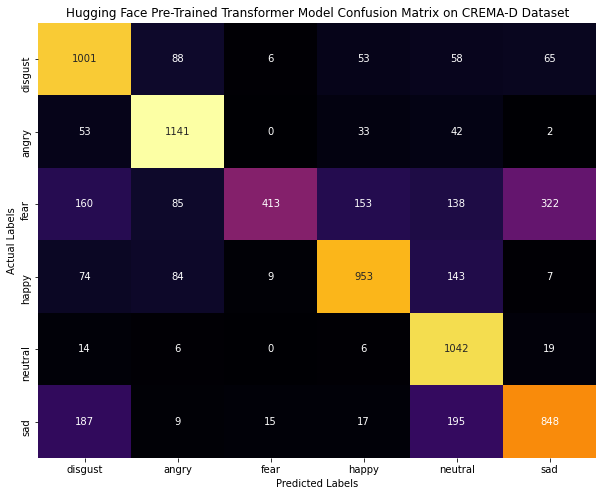

In [18]:
# Create confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels, labels=list(emotions.values()))

# Convert confusion matrix to DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix, index=list(emotions.values()), columns=list(emotions.values()))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, cmap='inferno', fmt='d', cbar=False)
plt.title('Hugging Face Pre-Trained Transformer Model Confusion Matrix on CREMA-D Dataset')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.savefig('../ds3-audio/confusion_matrix_img/CM_crema_wav_f')
plt.show()

In [19]:
# args = TrainingArguments(
#                         evaluation_strategy='epoch',
#                         save_strategy='epoch',
#                         learning_rate=1e-5,
#                         per_device_train_batch_size=BATCH_SIZE,
#                         per_device_eval_batch_size=BATCH_SIZE,
#                         num_train_epochs=10,
#                         metric_for_best_model='accuracy',
#                         output_dir=DATA_DIR)

# args.set_dataloader(train_batch_size=BATCH_SIZE, eval_batch_size=BATCH_SIZE)

In [20]:
# Trainer.train(model, args)

In [21]:
from sklearn.metrics import classification_report, accuracy_score

# Generate classification report
classification_rep = classification_report(actual_labels, predicted_labels, target_names=list(emotions.values()), labels=list(emotions.values()))
print("Classification Report:")
print(classification_rep)

# Calculate accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)

print("Accuracy:", accuracy)

Classification Report:
              precision    recall  f1-score   support

     disgust       0.67      0.79      0.73      1271
       angry       0.81      0.90      0.85      1271
        fear       0.93      0.32      0.48      1271
       happy       0.78      0.75      0.77      1271
     neutral       0.64      0.96      0.77      1087
         sad       0.67      0.67      0.67      1271

   micro avg       0.73      0.73      0.73      7442
   macro avg       0.75      0.73      0.71      7442
weighted avg       0.75      0.73      0.71      7442

Accuracy: 0.7253426498253158
